In [135]:
#importing necessary packages
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import os
import seaborn as sns 
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [136]:
# reading the csv file 
data = pd.read_csv("train.csv")

In [137]:
data.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [138]:
data['Class'].value_counts()

MIDDLE    10804
YOUNG      6706
OLD        2396
Name: Class, dtype: int64

<AxesSubplot:>

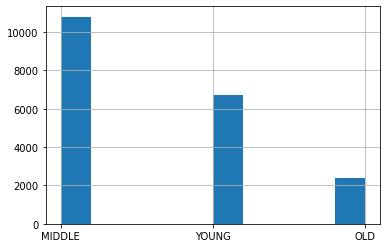

In [139]:
data['Class'].hist()

In [140]:
#classfication problem so encoding class into 0,1,2
# young=0,middle=1,old=2
data['Class'].replace(['YOUNG','MIDDLE','OLD'],[0,1,2],inplace=True)

In [141]:
data['Class'].value_counts()

1    10804
0     6706
2     2396
Name: Class, dtype: int64

In [142]:
#used in a image purpose for resizing
def readImage(path,ch = 3, resize=(150,150)):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=ch)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    img = tf.image.resize(img, resize)
    return img

In [143]:
# function to load the data that includes images and respective labels
def load_data(image_path, label):
    img = readImage(image_path, 3, (150,150))
    return (img, label)

In [144]:
# built the list of image paths and list of respective responses of the images
PATH = "Train"
image_paths = []
for path in os.listdir(PATH):
    image_paths.append(PATH+"/"+path)
print(len(image_paths))

label_list = []

for i in image_paths:
    _,tail = os.path.split(i)
    label = data.loc[data['ID'] == tail]['Class'].values[0]
    label_list.append(label)
print(len(label_list))

19906
19906


In [145]:
# split the dataset into train and test dataset
train_size = int(0.9*(len(image_paths)))
print(f"The training dataset size is {train_size}")
test_size = int(0.1*(len(image_paths)))
print(f"The testing dataset size is {test_size}")
#slicing dataset
train_set = tf.data.Dataset.from_tensor_slices((image_paths[:train_size], label_list[:train_size]))
test_set = tf.data.Dataset.from_tensor_slices((image_paths[test_size:], label_list[test_size:]))

The training dataset size is 17915
The testing dataset size is 1990


In [146]:
#autotuning train dataset
train_set = (train_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [147]:
#autotuining test dataset
test_set = (test_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [148]:
# building cnn layers
cnn_model = models.Sequential([
    layers.Conv2D(filters=30, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), padding = 'same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])


In [149]:
# view the summary of the cnn model
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 150, 150, 30)      840       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 75, 75, 30)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 75, 75, 64)        17344     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 87616)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                5607488   
_________________________________________________________________
dense_7 (Dense)              (None, 3)                

In [174]:
# compile the model
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [175]:
# fit the model
cnn_model.fit(train_set, epochs=20, validation_data=test_set)
#as we didn't performed data augmentation so we used 20 epochs

Epoch 1/20
280/280 [==============================] - 26s 90ms/step - loss: 0.0966 - accuracy: 0.9661 - val_loss: 0.3528 - val_accuracy: 0.9071
Epoch 2/20
280/280 [==============================] - 26s 92ms/step - loss: 0.0791 - accuracy: 0.9717 - val_loss: 0.4092 - val_accuracy: 0.9028
Epoch 3/20
280/280 [==============================] - 24s 87ms/step - loss: 0.0762 - accuracy: 0.9733 - val_loss: 0.4560 - val_accuracy: 0.8969
Epoch 4/20
280/280 [==============================] - 24s 86ms/step - loss: 0.0774 - accuracy: 0.9718 - val_loss: 0.3995 - val_accuracy: 0.9109
Epoch 5/20
280/280 [==============================] - 25s 89ms/step - loss: 0.0684 - accuracy: 0.9763 - val_loss: 0.4812 - val_accuracy: 0.8965
Epoch 6/20
280/280 [==============================] - 27s 95ms/step - loss: 0.0604 - accuracy: 0.9794 - val_loss: 0.4071 - val_accuracy: 0.9199
Epoch 7/20
280/280 [==============================] - 24s 84ms/step - loss: 0.0592 - accuracy: 0.9793 - val_loss: 0.4302 - val_accuracy:

In [176]:
#evaluating training set
cnn_model.evaluate(train_set)

280/280 [==============================] - 13s 47ms/step - loss: 0.0603 - accuracy: 0.9813


[0.0603117011487484, 0.9813005924224854]

In [177]:
# test accuracy
cnn_model.evaluate(test_set)

280/280 [==============================] - 12s 44ms/step - loss: 0.4078 - accuracy: 0.9493


[0.40782010555267334, 0.9492632150650024]

In [178]:
#test set predictions
test_pred = cnn_model.predict(test_set)
test_pred

array([[1.00e+00, 2.00e-16, 6.65e-26],
       [1.00e+00, 4.52e-04, 6.27e-07],
       [4.98e-09, 1.00e+00, 2.04e-10],
       ...,
       [6.09e-01, 3.91e-01, 8.88e-15],
       [9.83e-01, 1.75e-02, 2.70e-16],
       [1.95e-04, 9.84e-01, 1.57e-02]], dtype=float32)

In [179]:
y_labels = [np.argmax(item) for item in test_pred] #extract the predicted label for each
print("Test Predictions response sample:",y_labels[:10])

test_response = response_list[test_size:]
print("Test True response sample:", test_response[:10])

#checking for first 10 samples

Test Predictions response sample: [0, 0, 1, 1, 1, 1, 0, 1, 0, 1]
Test True response sample: [0, 0, 1, 1, 1, 1, 0, 1, 0, 1]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

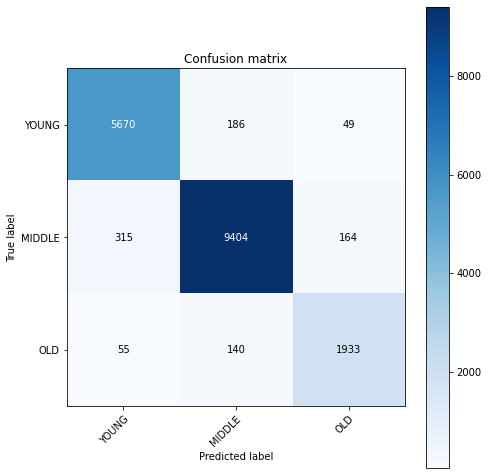

In [181]:
# funtion to plot confusion matrix to check the accuracy of each class value
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)
# plotting confusion matrix
plot_confusion_matrix(y_labels, test_response, classes=class_names,
                      title='Confusion matrix')

In [182]:
# accuracy of our model
print("Accuracy of CNN Model is:   %0.3f percentage" % (metrics.accuracy_score(test_response, y_labels)*100))

Accuracy of CNN Model is:   94.926 percentage


In [183]:
#Finding the values from our new test dataset

# built the list of image paths and list of respective responses of the images
PATH = "Test"
image_paths_1 = []
for path in os.listdir(PATH):
    image_paths_1.append(PATH+"/"+path)
print(len(image_paths_1))

10


In [184]:
import cv2
#preprocessing for our new dataset
def preprocess_image(image_paths_1):
    image = cv2.imread(image_paths_1)
    image = cv2.resize(image, (150,150))
    return image

In [ ]:
res=[]
file=[]
for image_path in image_paths_1:
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)
    # Get the predictions
    predictions = cnn_model.predict(image)
    y_labels_1 = [np.argmax(item) for item in predictions]
    label_mapping = {0: 'YOUNG', 1: 'MIDDLE', 2: 'OLD'}
    y_labels_1 = [label_mapping[label] for label in y_labels_1]
    file.append(os.path.basename(image_path))
    res.append(''.join(y_labels_1))

In [190]:
#creating dataframe
results_df = pd.DataFrame({"Image": file, "Class": res})

In [191]:
#final result
results_df

,Image,Class
0,26526.jpg,MIDDLE
1,26528.jpg,MIDDLE
2,26527.jpg,MIDDLE
3,26524.jpg,YOUNG
4,26523.jpg,MIDDLE
5,26505.jpg,MIDDLE
6,26521.jpg,MIDDLE
7,26492.jpg,MIDDLE
8,26530.jpg,MIDDLE
9,26483.jpg,YOUNG
